In [171]:
import matplotlib.pyplot as plt
import numpy as np
import importlib
import Scsv


In [172]:
# %matplotlib widget

In [173]:
%matplotlib

Using matplotlib backend: agg


In [174]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import sys
from operator import add

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import Word2Vec
from pyspark.ml.feature import StopWordsRemover

In [175]:
def plotVecs(oname, wds, vecs, count, color):
    plt.ioff()
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    for i in range(count):
        coords = vecs[i][0]
        ax.scatter(*coords, c=color)
        pass

    # too much too slow and crowded, disabled
    # label = str(wds[i][0])
    # ax.text(*coords, label)

    plt.savefig(f"/opt/spark/myProj/plots/out-{oname}.png")
    plt.close()
    return fig # in jupyter

def plotBothVecs(oname, wds, vecs, count, color, wds2, vecs2, count2, color2):
    plt.ioff()
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    for i in range(count):
        coords = vecs[i][0]
        ax.scatter(*coords, c=color)
        pass
    
    for i in range(count2):
        coords = vecs2[i][0]
        ax.scatter(*coords, c=color2)
        pass

    # too much too slow and crowded, disabled
    # label = str(wds[i][0])
    # ax.text(*coords, label)

    plt.savefig(f"/opt/spark/myProj/plots/out-{oname}.png")
    plt.close()
    return fig # in jupyter

In [176]:
MASTER= "spark://virtual01-virtualbox:7077"
# MASTER= "local[*]"

spark = SparkSession.builder\
    .appName("MyProj")\
    .master(MASTER)\
    .config("spark.sql.repl.eagerEval.enabled", True)\
    .getOrCreate()

fname="hdfs://zuk:9000/dataset/twitter/Tweets.csv"

In [177]:
df = spark.read.option("header",True).csv(fname)\
    .select("airline_sentiment","text")

rter = RegexTokenizer(inputCol="text", outputCol="token", pattern="[\\W]+", minTokenLength=3)
tokenized = rter.transform(df.na.fill(' '))

In [186]:
more_stopwords=["virginamerica","https","ual","nyc"]
more_stopwords.extend(StopWordsRemover().getStopWords())

remover = StopWordsRemover(inputCol="token", outputCol="rtoken").setStopWords(more_stopwords)
removed = remover.transform(tokenized)

removed.count()

14837

In [187]:
removed.select("airline_sentiment","rtoken").limit(10)

airline_sentiment,rtoken
neutral,"[dhepburn, said]"
positive,"[plus, added, com..."
neutral,"[didn, today, mus..."
negative,"[really, aggressi..."
negative,"[really, big, bad..."
negative,"[seriously, pay, ..."
,[]
positive,"[yes, nearly, eve..."
neutral,"[really, missed, ..."
positive,"[well, didn]"


In [188]:
oname = fname.replace("/", "").replace(":", "")
# !transform data

word2Vec = Word2Vec(vectorSize=3, minCount=1,
                    inputCol="rtoken", outputCol="vector")

model = word2Vec.fit(removed)


result = model.transform(removed)

In [189]:
samples = 1000

wds1 = result.select("rtoken")\
    .filter("airline_sentiment = \"positive\" OR airline_sentiment = \"neutral\"")\
    .head(samples)
vecs1 = result.select("vector")\
    .filter("airline_sentiment = \"positive\" OR airline_sentiment = \"neutral\"")\
    .head(samples)

wds2 = result.select("rtoken")\
    .filter(result.airline_sentiment =="negative")\
    .head(samples)
vecs2 = result.select("vector")\
    .filter(result.airline_sentiment =="negative")\
    .head(samples)

cnt1 = len(vecs1)
cnt2 = len(vecs2)

In [190]:
display(wds1[0:5])
display(wds2[0:5])

[Row(rtoken=['dhepburn', 'said']),
 Row(rtoken=['plus', 'added', 'commercials', 'experience', 'tacky']),
 Row(rtoken=['didn', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip']),
 Row(rtoken=['yes', 'nearly', 'every', 'time', 'fly', 'ear', 'worm', 'won', 'away']),
 Row(rtoken=['really', 'missed', 'prime', 'opportunity', 'men', 'without', 'hats', 'parody', 'mwpg7grezp'])]

[Row(rtoken=['really', 'aggressive', 'blast', 'obnoxious', 'entertainment', 'guests', 'faces', 'amp', 'little', 'recourse']),
 Row(rtoken=['really', 'big', 'bad', 'thing']),
 Row(rtoken=['seriously', 'pay', 'flight', 'seats', 'didn', 'playing']),
 Row(rtoken=['sfo', 'pdx', 'schedule', 'still', 'mia']),
 Row(rtoken=['flew', 'sfo', 'last', 'week', 'couldn', 'fully', 'sit', 'seat', 'due', 'two', 'large', 'gentleman', 'either', 'side', 'help'])]

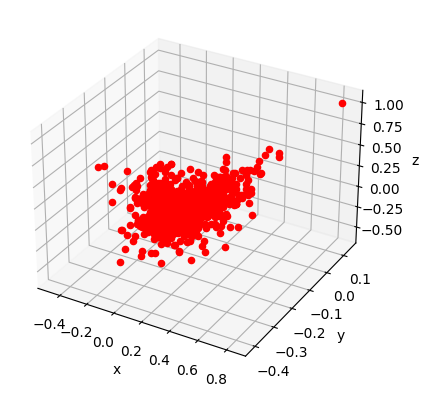

In [60]:
plotVecs(oname+"pos", wds1, vecs1, cnt1,"red")


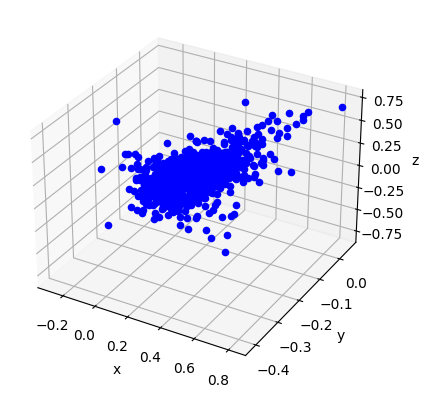

In [61]:
plotVecs(oname+"neg", wds2, vecs2, cnt2,"blue")

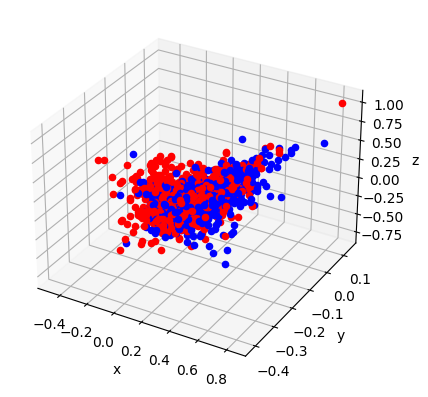

In [63]:
plotBothVecs(oname+"both1", wds2, vecs2, cnt2, "blue",  wds1, vecs1, cnt1, "red")

In [196]:
model.findSynonyms("again",10)


Py4JJavaError: An error occurred while calling o6278.findSynonyms.
: java.lang.IllegalStateException: again not in vocabulary
	at org.apache.spark.mllib.feature.Word2VecModel.transform(Word2Vec.scala:545)
	at org.apache.spark.mllib.feature.Word2VecModel.findSynonyms(Word2Vec.scala:557)
	at org.apache.spark.ml.feature.Word2VecModel.findSynonymsArray(Word2Vec.scala:270)
	at org.apache.spark.ml.feature.Word2VecModel.findSynonyms(Word2Vec.scala:234)
	at jdk.internal.reflect.GeneratedMethodAccessor232.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [197]:
result.printSchema()
result.count()

root
 |-- airline_sentiment: string (nullable = false)
 |-- text: string (nullable = false)
 |-- token: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rtoken: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- vector: vector (nullable = true)



14837

In [198]:
from pyspark.sql.functions import col
df1 = df.filter("airline_sentiment = \"positive\" OR airline_sentiment = \"neutral\" OR airline_sentiment = \"negative\"")
# unknown sentiment values are removed

df1.groupBy("airline_sentiment")\
    .count()\
    .orderBy(col("count").desc())\
    .show()

+-----------------+-----+
|airline_sentiment|count|
+-----------------+-----+
|         negative| 9178|
|          neutral| 3099|
|         positive| 2363|
+-----------------+-----+



In [199]:
# pipelined, very simplified

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

df2 =  df1.na.fill("")
label_stringIdx = StringIndexer(inputCol="airline_sentiment", outputCol="label")

pipeline=Pipeline(stages = [rter, remover, word2Vec,label_stringIdx])

pipelineFit = pipeline.fit(df2)

df3 = pipelineFit.transform(df2)
display(df3)

airline_sentiment,text,token,rtoken,vector,label
neutral,@VirginAmerica Wh...,"[virginamerica, w...","[dhepburn, said]",[0.15238755196332...,1.0
positive,@VirginAmerica pl...,"[virginamerica, p...","[plus, added, com...",[0.19570518881082...,2.0
neutral,@VirginAmerica I ...,"[virginamerica, d...","[didn, today, mus...",[0.16798651590943...,1.0
negative,"""@VirginAmerica i...","[virginamerica, r...","[really, aggressi...",[0.05313765360042...,0.0
negative,@VirginAmerica an...,"[virginamerica, a...","[really, big, bad...",[0.25096611678600...,0.0
negative,@VirginAmerica se...,"[virginamerica, s...","[seriously, pay, ...",[0.09173630084842...,0.0
positive,@VirginAmerica ye...,"[virginamerica, y...","[yes, nearly, eve...",[0.13982654404309...,2.0
neutral,@VirginAmerica Re...,"[virginamerica, r...","[really, missed, ...",[0.11513637709948...,1.0
positive,@virginamerica We...,"[virginamerica, w...","[well, didn]",[0.12383361160755...,2.0
positive,@VirginAmerica it...,"[virginamerica, w...","[amazing, arrived...",[0.28151428997516...,2.0


In [200]:
# training (multi-class-text-classification-with-pyspark)
# ref: https://towardsdatascience.com/multi-class-text-classification-with-pyspark-7d78d022ed35

(trainingDf, testDf) = df3.randomSplit([0.75,0.25], seed=100)

print(f"train = {trainingDf.count()}, test count= {testDf.count()}")

train = 11041, test count= 3599


In [201]:
# lr classifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0,
                       featuresCol="vector")
lrModel=lr.fit(trainingDf)

predictions = lrModel.transform(testDf)



predictions.filter(predictions['prediction'] == 0) \
    .orderBy("probability", ascending=False) \
    .limit( 10)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.507327121390643

In [202]:
# random forest
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="vector", \
                            numTrees = 100)# Train model with Training Data
rfModel = rf.fit(trainingDf)

predictions = rfModel.transform(testDf)

predictions.filter(predictions['prediction'] == 0) \
    .orderBy("probability", ascending=False) \
    .limit(10)


evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.5646474246962085

In [203]:
# perceptron classifier
# ref: https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier

from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
#layers = [4, 5, 4, 3]
layers = [3, 5, 4, 3]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234, featuresCol="vector")

# train the model
pmodel = trainer.fit(trainingDf)

# compute accuracy on the test set
presult = pmodel.transform(testDf)
predictionAndLabels = presult.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Test set accuracy = 0.6446235065295916
